https://github.com/tsvtkv/jigsaw-puzzle


In [1]:
EMPTY_SLOT = -1
INFINITY = 10**9
EPSILON = 0.1**6

In [2]:
import os

from PIL import Image


def min_max(iterable):
    it = iter(iterable)
    _min = next(it)
    _max = _min
    for element in it:
        if element < _min:
            _min = element
        if element > _max:
            _max = element

    return _min, _max


def is_image_file(_file):
    return os.path.isfile(_file) and _file.endswith('.png')


def list_images(directory):
    files = (os.path.join(directory, _file) for _file in os.listdir(directory))
    image_paths = (_file for _file in files if is_image_file(_file))
    return image_paths


def read_pieces(directory):
    image_paths = list_images(directory)
    pieces = [Image.open(f) for f in image_paths]

    sizes = {piece.size for piece in pieces}
    if len(sizes) != 1:
        raise ValueError('not all pieces are compatible by size')

    size = sizes.pop()
    if size[0] != size[1]:
        raise ValueError('pieces are not square')

    return pieces

In [3]:
import math
import numpy as np

def _avg_difference(npiece, side):
    if side == LEFT:
        difference = npiece[:, 0] - npiece[:, 1]
    elif side == RIGHT:
        difference = npiece[:, -1] - npiece[:, -2]
    elif side == UP:
        difference = npiece[0, :] - npiece[1, :]
    else:
        difference = npiece[-1, :] - npiece[-2, :]

    return sum(difference)/float(len(difference))


def _gradient(pieces_difference, average_side_difference):
    grad = pieces_difference - average_side_difference
    grad_t = np.transpose(grad)
    cov = np.cov(grad_t)
    try:
        cov_inv = np.linalg.inv(cov)
    except np.linalg.LinAlgError as e:
        cov_inv = np.ones((3, 3))

    return grad.dot(cov_inv).dot(grad_t)


def mgc(np1, np2, relation):
    if relation == LEFT:
        grad_12 = _gradient(np2[:, 0] - np1[:, -1], _avg_difference(np1, RIGHT))
        grad_21 = _gradient(np1[:, -1] - np2[:, 0], _avg_difference(np2, LEFT))
    else:
        grad_12 = _gradient(np2[0, :] - np1[-1, :], _avg_difference(np1, DOWN))
        grad_21 = _gradient(np1[-1, :] - np2[0, :], _avg_difference(np2,UP))

    return np.sum(grad_12 + grad_21)


def rgb(np1, np2, relation):
    if relation ==LEFT:
        difference = np1[:, -1] - np2[:, 0]
    else:
        difference = np1[-1, :] - np2[0, :]

    exponent = np.vectorize(lambda x: math.pow(x, 2))
    dissimilarity = np.sum(exponent(difference))
    return math.sqrt(dissimilarity)


def rgb_mgc(*args):
    return rgb(*args)*mgc(*args)

In [4]:
import random
from itertools import product


def generate_puzzle(image, piece_size):
    width, height = image.size
    width_steps = range(0, width, piece_size)
    height_steps = range(0, height, piece_size)
    boxes = ((i, j, i+piece_size, j+piece_size)
             for i, j in product(width_steps, height_steps))

    pieces = [image.crop(box) for box in boxes]
    random.shuffle(pieces)

    return pieces, len(width_steps), len(height_steps)

In [71]:
import numpy as np
from PIL import Image
from itertools import product


class PuzzleSolver(object):
    def __init__(self, dissimilarity_measure):
        self.dissimilarity = dissimilarity_measure
        self.pieces = []
        self.edges = []
        self.weights = []
        self.positions = []
        self.puzzle_height = 0
        self.puzzle_width = 0

    def solve_puzzle(self, pieces, puzzle_height, puzzle_width):
        self.puzzle_height = puzzle_height
        self.puzzle_width = puzzle_width
        self.pieces = pieces
        self.edges = [(i, j, rel)
                      for (i, j, rel) in product(self.pieces_range, self.pieces_range,BASIC)
                      if i != j]
        self.weights = self.__compute_weights()
        self.edges.sort(key=lambda x: self.weights[x])

        positions = self.__initial_positions()
        piece_placement = self.__place_pieces(positions)
        unused_pieces = set(self.pieces_range) - set(piece_placement.flatten())
        piece_placement = self.__fill_unused(piece_placement, unused_pieces)

        image = Image.new('RGB', (self.puzzle_width*self.piece_size, self.puzzle_height*self.piece_size))
        self.__paste_pieces(image, piece_placement)

        return image

    def get_pieces_count(self):
        return len(self.pieces)

    def get_pieces_range(self):
        return range(self.pieces_count)

    def get_piece_size(self):
        if not self.pieces:
            return 0
        return self.pieces[0].size[0]

    def get_dissimilarity(self, p_1, p_2, rel):
        if rel not in BASIC:
            p_1, p_2, rel = p_2, p_1, SYMMETRIC[rel]
        return self.weights[p_1, p_2, rel]

    pieces_count = property(get_pieces_count)
    pieces_range = property(get_pieces_range)
    piece_size = property(get_piece_size)

    def __compute_weights(self):
        npieces = [np.array(piece) for piece in self.pieces]
        weights = np.zeros((self.pieces_count, self.pieces_count, 4), dtype=np.float)
        weights.fill(INFINITY)
        for i, j, rel in self.edges:
            weights[i, j, rel] = self.dissimilarity(npieces[i], npieces[j], rel)

        normalized_weights = np.array(weights)
        for i, j, rel in self.edges:
            min_weight = min(weights[i, :, rel].min(), weights[:, j, rel].min())
            normalized_weights[i, j, rel] = weights[i, j, rel] / (min_weight + EPSILON)

        return normalized_weights

    def __initial_positions(self):
        positions = np.zeros((self.pieces_count, 2), dtype=np.int32)
        trees = [{i} for i in range(self.pieces_count)]
        node_tree = [i for i in range(self.pieces_count)]
        relation_offset = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
        for i, j, rel in self.edges:
            tree_i, tree_j = node_tree[i], node_tree[j]
            if tree_i == tree_j:
                continue

            offset_j = positions[i] - positions[j] + relation_offset[rel]
            took_same_place = (np.all(positions[node_1] == positions[node_2] + offset_j)
                               for node_1, node_2 in product(trees[tree_i], trees[tree_j]))
            if any(took_same_place):
                continue

            trees[tree_i] = trees[tree_i].union(trees[tree_j])
            for node in trees[tree_j]:
                node_tree[node] = tree_i
                positions[node] += offset_j
        return positions

    def __place_pieces(self, positions):
        assembled_height, assembled_width, offset = PuzzleSolver.__origin_transform(positions)
        positions = np.add(positions, offset)

        placement = np.zeros((assembled_height, assembled_width), dtype=np.int32)
        placement.fill(EMPTY_SLOT)
        for i, position in enumerate(positions):
            placement[tuple(position)] = i

        self.puzzle_height = min(self.puzzle_height, assembled_height)
        self.puzzle_width = min(self.puzzle_width, assembled_width)

        min_x, min_y, min_empty = 0, 0, INFINITY
        for x_offset in range(assembled_width - self.puzzle_width):
            for y_offset in range(assembled_height - self.puzzle_height):
                y_1, y_2 = y_offset, y_offset + self.puzzle_height
                x_1, x_2 = x_offset, x_offset + self.puzzle_width
                empty = np.where(placement[y_1:y_2, x_1:x_2] == EMPTY_SLOT)
                empty_count = np.count_nonzero(empty)
                if empty_count < min_empty:
                    min_x, min_y, min_empty = x_offset, y_offset, empty_count

        return placement[min_y:min_y+self.puzzle_height, min_x:min_x+self.puzzle_width]

    @staticmethod
    def __origin_transform(positions):
        top, bottom = min_max(positions[:, 0])
        left, right = min_max(positions[:, 1])
        height = (bottom-top + 1)
        width = (right-left + 1)
        offset = np.array([-top, -left])

        return height, width, offset

    def __fill_unused(self, piece_placement, unused_pieces):
        def is_nonempty(x, y):
            h, w = piece_placement.shape
            return 0 <= x < w and 0 <= y < h and piece_placement[y, x] != EMPTY_SLOT

        def get_neighbours(x, y):
            if is_nonempty(x-1, y):
                yield LEFT, piece_placement[y, x-1]
            if is_nonempty(x+1, y):
                yield RIGHT, piece_placement[y, x+1]
            if is_nonempty(x, y-1):
                yield UP, piece_placement[y-1, x]
            if is_nonempty(x, y+1):
                yield DOWN, piece_placement[y+1, x]

        def get_neighbour_dissimilarity(piece, neighbours):
            dissimilarities = [self.get_dissimilarity(nb, piece, rel) for rel, nb in neighbours]
            dissimilarity = sum(dissimilarities) /max(1,len(dissimilarities))
            
            if dissimilarity < EPSILON:
                return INFINITY
            return dissimilarity

        empty_slots = {(x, y) for x, y in product(range(self.puzzle_width), range(self.puzzle_height))
                       if piece_placement[y, x] == EMPTY_SLOT}
        while empty_slots and unused_pieces:
            slots_neighbours = [(x, y, list(get_neighbours(x, y))) for x, y in empty_slots]

            x, y, neighbours = max(slots_neighbours, key=lambda  nbs : len(nbs) )      #modif
            best_fit = min(unused_pieces, key=lambda p: get_neighbour_dissimilarity(p, neighbours))

            piece_placement[y, x] = best_fit
            unused_pieces.remove(best_fit)
            empty_slots.remove((x, y))

        return piece_placement

    def __paste_pieces(self, image, piece_placement):
        for x, y in product(range(self.puzzle_width), range(self.puzzle_height)):
            if piece_placement[y, x] != EMPTY_SLOT:
                piece = piece_placement[y, x]
                box = (x, y, x+1, y+1)
                box = list(map(lambda v: v*self.piece_size, box)) #modif
                image.paste(self.pieces[piece], box)

In [72]:
LEFT = 0
RIGHT = 1
UP = 2
DOWN = 3
BASIC = (LEFT, UP)
SYMMETRIC = (RIGHT, LEFT, DOWN, UP)

In [158]:
image = Image.open('jigsaw-puzzle-master/examples/street.jpg')
piece_size=40;
pieces, puzzle_width, puzzle_height = generate_puzzle(image,piece_size)

In [159]:
400**2

160000

In [160]:
output_path='jigsaw-puzzle-master/examples/res'

In [161]:
for i, piece in enumerate(pieces):
    piece_path = os.path.join(output_path, '%i.png' % (i,))
    piece.save(piece_path)

print ('Puzzle saved to: %s' % (output_path,) )
print ('Puzzle sizes: width=%i, height=%i' % (puzzle_width, puzzle_height) )

Puzzle saved to: jigsaw-puzzle-master/examples/res
Puzzle sizes: width=9, height=12


In [162]:
solver = PuzzleSolver(rgb_mgc)
#pieces = read_pieces(output_path)
solution = solver.solve_puzzle(pieces, puzzle_height,puzzle_width)
solution.save('jigsaw-puzzle-master/examples/res/sol.jpg')
print ('Resulting image saved to: %s' % ('jigsaw-puzzle-master/examples/res'))

Resulting image saved to: jigsaw-puzzle-master/examples/res


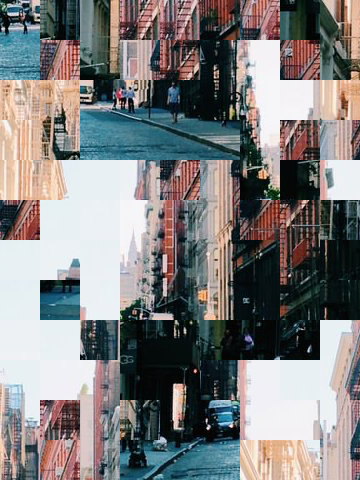

In [163]:
solution

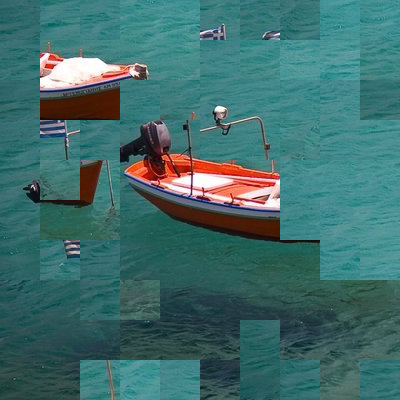

In [157]:
solution